In [ ]:

!pip uninstall -y torch torchvision torchaudio transformers accelerate bitsandbytes

!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

!pip install -q --upgrade transformers datasets accelerate evaluate scikit-learn pandas openpyxl geopy sentence-transformers peft ftfy seaborn matplotlib bitsandbytes country_converter pycountry optuna




In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import re
import time
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification,
    pipeline,
    TrainingArguments,
    Trainer
)
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from tqdm.auto import tqdm
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable, GeocoderServiceError
from sentence_transformers import SentenceTransformer, util
import ftfy
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import difflib
from getpass import getpass
from google.colab import userdata
import huggingface_hub
from torch import nn


In [ ]:
hf_token = userdata.get('HF_TOKEN').strip()
huggingface_hub.login(token=hf_token)


Successfully logged into Hugging Face.


In [ ]:
test_df = pd.read_excel('llama3_zeroshot_summary_results.xlsx') ### WITH SUMMARY INCLUDED OK
test_df = test_df[['Final_Summary', 'Category']]
test_df.head()

,Final_Summary,Category
0,The Kwara State Government has reopened the Kw...,Civil unrest
1,"Phrank Shaibu, Special Assistant to Atiku Abub...",Other
2,"Minister of Interior, Rauf Aregbesola, has emp...",Other
3,The Atiku-Okowa Presidential Campaign Organisa...,Other
4,Troops from Operation Forest Sanity neutralize...,Crime


In [ ]:
categories = test_df['Category'].unique().tolist()

print(f"Data shape: {test_df.shape}")
print(f"Categories found: {categories}")
category_list_str = ", ".join(f"'{name}'" for name in categories)


--- Test Data Ready ---
Data shape: (856, 2)
Categories found: ['Civil unrest', 'Other', 'Crime', 'Road traffic accident', 'Kidnapping', 'Environmental & Infrastructure', 'Terrorism and political violence acts', 'Medical']


In [ ]:
category_definitions = {
    "Terrorism and political violence acts":
        "Use when organised armed actors (militants, insurgents, separatists, unknown gunmen) "
        "attack civilians or state targets **to intimidate or coerce**. **There must be a  clear political / "
        "ideological motive** OR a pattern of armed raids counts, even if no ransom is demanded. "
        "EXCLUDE: hostage-taking for ransom only → Kidnapping; spontaneous crowds → Civil unrest; no ideological motive → Crime. ",

    "Kidnapping":
        "Any seizure or abduction of people (hostage-taking, crew hijack, child snatch, ‘one-chance’ robberies) "
        "where **the primary act is holding victims**. Motive may be ransom, robbery or revenge. "
        "EXCLUDE: abduction named as part of an armed political attack → Terrorism and political violence acts; no persons seized → Crime.",

    "Civil unrest":
        "Crowd actions such as protests, strikes, road blockages or riots **without organised use of guns or bombs**. "
        "EXCLUDE: armed assault or bomb attack during a protest → Terrorism and political violence acts; single-perpetrator thefts → Crime.",

    "Road traffic accident":
        "Unintentional collision or vehicle crash on roads causing injury, death or traffic delay. "
        "EXCLUDE: driver deliberately rams for ideological reasons → Terrorism and political violence acts; crash triggered by flood/landslide → Environmental & Infrastructure.",

    "Crime":
        "Any act that is punishable by law (killing, theft, robbery, assault, fraud, homicide, manslaughter) **that is NOT abduction and NOT politically-motivated violence**. "
        "EXCLUDE: any hostage-taking or abduction → Kidnapping; attack by militants or insurgents → Terrorism and political violence acts.",

    "Environmental & Infrastructure":
        "Natural disasters (flood, storm, quake, wildfire, landslide) OR infrastructure / utility failures "
        "(bridge collapse, power-grid outage, dam burst, major road closure). "
        "EXCLUDE: routine vehicle crashes → Road traffic accident; stories focused on health policy → Medical.",

    "Medical":
        "Disease outbreaks, epidemics, infections, heatwaves, public-health advisories **and active health-emergency responses**. "
        "EXCLUDE: general health-agency staffing, budgets, new researches or lab upgrades with no health threat → Other.",

    "Other":
        "Everything else: elections, economics, business, culture, science **unless** the story fits one of the definitions above. "
        "EXCLUDE: any article mentioning an abduction, armed attack, disease outbreak, natural disaster, or power/bridge failure.",
}
definitions_str = "\n".join([f"- '{name}': {desc}" for name, desc in category_definitions.items()])



In [ ]:

#### HERE STATIC SHOTS ARE USED AS THE REASONING TEMPLATES NEEDS TO BE DESIGNED, THERE WAS NO WAY TO DESIGN FOR ALL OF THE TRAINING DATASET

STATIC_COT = [
    {
        "article":
        "Armed bandits kidnapped 317 school-girls in Zamfara State and demanded ransom. Officials say the attackers are profit-driven bandits who have carried out similar mass abductions for ransom.",
        "label": "Kidnapping",
        "reason": [
            "Seizure of persons = abduction.",
            "Ransom motive, no ideology mentioned.",
            "No bombs or political demands."
        ],
    },
    {
        "article":
        "A suicide bomber killed 27 worshippers in a Kandahar mosque; Islamic State later claimed the attack.",
        "label": "Terrorism and political violence acts",
        "reason": [
            "Suicide bomb => organised lethal violence.",
            "Religious target + IS claim => ideological motive.",
            "Goal is intimidation of civilians."
        ],
    },
    # {
    #     "article":
    #     "Seoul closed Tongin night-market for two weeks after 83 food-poisoning cases linked to one crab stall.",
    #     "label": "Other",
    #     "reason": [
    #         "Story is a local governance decision (market closure).",
    #         "Incident is food-safety, not an epidemic.",
    #         "No national health emergency."
    #     ],
    # },
    # {
    #     "article":
    #     "Thousands of miners blocked the La Paz highway, hurling stones at riot police; no firearms used.",
    #     "label": "Civil unrest",
    #     "reason": [
    #         "Crowd protest blocks road.",
    #         "Clashes but no guns or bombs.",
    #         "Miners are civilians, no named group."
    #     ],
    # },

    # {
    #     "article":
    #     "Masked thieves broke into a Lagos jewellery store at night, knifed the guard and stole $200 k in gold.",
    #     "label": "Crime",
    #     "reason": [
    #         "Robbery + assault = punishable offence.",
    #         "No abduction, no ideology.",
    #         "Motive is financial."
    #     ],
    # },

    # {
    #     "article":
    #     "A bus collided with a fuel-tanker on the Nairobi-Mombasa highway, killing 14 passengers and injuring 32.",
    #     "label": "Road traffic accident",
    #     "reason": [
    #         "Unintentional vehicle crash.",
    #         "Pure traffic incident.",
    #     ],
    # },

    # {
    #     "article":
    #     "Monsoon floods in Kerala washed away a bridge, cutting road links to five villages and causing power outages.",
    #     "label": "Environmental & Infrastructure",
    #     "reason": [
    #         "Natural disaster (flood).",
    #         "Bridge collapse, utility disruption.",
    #     ],
    # },

    {
        "article":
        "Haiti’s health ministry confirmed 125 new cholera cases in Port-au-Prince and began an emergency vaccination drive.",
        "label": "Medical",
        "reason": [
            "Disease outbreak reported.",
            "Health-sector emergency response.",
        ],
    },
]

In [ ]:
def create_cot_prompt(article_text: str, category_list: list[str],tokenizer):




    cats_json = ", ".join(f'"{c}"' for c in category_list)
    system_msg = (
        "You are a strict news-classification engine.\n"
        "First think step-by-step under the heading **Reasoning:**.\n"
        "Then, on a new line that begins with **Answer:** output exactly ONE JSON "
        "object whose only key is \"label\".\n"
        f"The value of \"label\" MUST be one of: [{cats_json}].\n"
        "If uncertain, pick the single best-matching category.\n"
        "Base your choice **ONLY on the definitions, the examples, "
        "and the article**."
    )
    messages = [{"role": "system", "content": system_msg}]


    user_block = f"""
Definitions:
{definitions_str}

ARTICLE:
{article_text}

Think step-by-step, Then output **exactly** {{"label":"<category>"}} (no newlines).
""".strip()
    messages.append({"role": "user", "content": user_block})

    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    prompt = prompt.replace(
        tokenizer.eos_token + "<|start_header_id|>assistant<|end_header_id|>",
        "<|start_header_id|>assistant<|end_header_id|>"
    )
    return prompt


def parse_llm_response(resp: str, valid_categories: list[str]) :

    _, _, assistant = resp.rpartition("<|start_header_id|>assistant<|end_header_id|>")
    if not assistant:
        assistant = resp

    for m in reversed(list(re.finditer(r"\{[^{}]*\}", assistant, flags=re.DOTALL))):
        try:
            label = json.loads(m.group())["label"].strip()
            if label in valid_categories:
                return label
        except Exception:
            continue

    pats = "|".join(re.escape(c) for c in valid_categories)
    m = re.search(rf"\b({pats})\b", assistant, flags=re.IGNORECASE)
    if m:
        return next(c for c in valid_categories if c.lower() == m.group(1).lower())

    print("\n\nResponse of the text: ", resp,"\n")
    return "Invalid Output"


def _fallback_best_match(text: str, valid_categories: list[str]):

    match = difflib.get_close_matches(text, valid_categories, n=1, cutoff=0.0)
    print(match)
    return match[0] if match else "Invalid Output"

In [ ]:
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"
BATCH_SIZE = 16

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

print(f"Loading model: {MODEL_ID}...")
model_llm = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=quantization_config,
    device_map="auto",

)
tokenizer_llm = AutoTokenizer.from_pretrained(MODEL_ID)

pipe = pipeline(
    "text-generation",
    model=model_llm,
    tokenizer=tokenizer_llm,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

if pipe.tokenizer.pad_token is None:
    pipe.tokenizer.pad_token = pipe.tokenizer.eos_token


Loading model: meta-llama/Meta-Llama-3-8B-Instruct...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


Model loaded successfully.
Tokenizer padding token configured for batching.


In [ ]:

prompts = [create_cot_prompt(summary, categories, tokenizer_llm) for summary in test_df['Final_Summary']]
print(f"{len(prompts)} prompts created.")
prompts[1]

In [ ]:
outputs = pipe(prompts, max_new_tokens=500, do_sample=True,temperature=0.3,top_p = 0.90 ,batch_size=BATCH_SIZE)


In [ ]:
llm_predictions = [parse_llm_response(result[0]['generated_text'], categories) for result in tqdm(outputs, desc="Parsing results")]
raw_outputs = [result[0]['generated_text'] for result in tqdm(outputs, desc="Extracting raw outputs")]


Parsing results:   0%|          | 0/856 [00:00<?, ?it/s]

Extracting raw outputs:   0%|          | 0/856 [00:00<?, ?it/s]

In [ ]:
test_df['LLM_Predicted'] = llm_predictions
test_df['Raw_Output'] = raw_outputs

true_labels = test_df['Category']

In [ ]:

print("\n" + "="*80)
print(f" " * 15 + f"Final Performance Report for {MODEL_ID}")
print("="*80)

accuracy = accuracy_score(true_labels, llm_predictions)
f1_macro = f1_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)
precision_macro = precision_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)
recall_macro = recall_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)

report_dict = {
    "accuracy": accuracy,
    "f1_macro": f1_macro,
    "precision_macro": precision_macro,
    "recall_macro": recall_macro
}

print("\n--- Key Performance Metrics ---")
for metric, value in report_dict.items():
    print(f"{metric:<18}: {value:.4f}")

all_possible_outcomes = categories + ['Invalid Output'] if 'Invalid Output' in set(llm_predictions) else categories
full_report = classification_report(
    true_labels,
    llm_predictions,
    labels=all_possible_outcomes,
    target_names=all_possible_outcomes,
    zero_division=0
)
print(full_report)
print("="*80)

try:
    test_df[['Final_Summary', 'Category', 'LLM_Predicted','Raw_Output']].to_excel("llama3_CoT_results_classification.xlsx", index=False)
    print(f"\nFull results with predictions saved to 'llama3_CoT_colab.xlsx'")

except Exception as e:
    print(f"\nCould not save results to Excel. Error: {e}")


               Final Performance Report for meta-llama/Meta-Llama-3-8B-Instruct

--- Key Performance Metrics ---
accuracy          : 0.7886
f1_macro          : 0.8029
precision_macro   : 0.8113
recall_macro      : 0.8035

--- Detailed Classification Report (including invalid outputs) ---
                                       precision    recall  f1-score   support

                         Civil unrest       0.87      0.87      0.87       114
                                Other       0.80      0.66      0.72       201
                                Crime       0.69      0.67      0.68       101
                Road traffic accident       0.95      0.94      0.94        62
                           Kidnapping       0.96      0.84      0.89       111
       Environmental & Infrastructure       0.90      0.81      0.85        53
Terrorism and political violence acts       0.65      0.69      0.67        85
                              Medical       0.68      0.95      0.79       12

In [ ]:

for i, result in enumerate(outputs[:20]):
    raw_response_text = result[0]['generated_text']

    parsed_category = parse_llm_response(raw_response_text, categories)

    print(f"\n----------- Article {i+1} -----------")
    print(f"RAW OUTPUT:\n{repr(raw_response_text)}")
    print("-" * 20)
    print(f"PARSED RESULT: '{parsed_category}'")
    print("-" * 20)


--- Comparing Raw Output vs. Parsed Output ---

----------- Article 1 -----------
RAW OUTPUT:
'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a strict news-classification engine.\nFirst think step-by-step under the heading **Reasoning:**.\nThen, on a new line that begins with **Answer:** output exactly ONE JSON object whose only key is "label".\nThe value of "label" MUST be one of: ["Civil unrest", "Other", "Crime", "Road traffic accident", "Kidnapping", "Environmental & Infrastructure", "Terrorism and political violence acts", "Medical"].\nIf uncertain, pick the single best-matching category.\nBase your choice **ONLY on the definitions, the examples, and the article**.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nDefinitions:\n- \'Terrorism and political violence acts\': Use when organised armed actors (militants, insurgents, separatists, unknown gunmen) attack civilians or state targets **to intimidate or coerce**. **There must be a  clear political /

In [ ]:
prediction_counts = test_df['LLM_Predicted'].value_counts()

print("--- Counts of Each Predicted Category ---")
print(prediction_counts)

--- Counts of Each Predicted Category ---
LLM_Predicted
Medical                                  180
Other                                    167
Civil unrest                             114
Crime                                     98
Kidnapping                                97
Terrorism and political violence acts     91
Road traffic accident                     61
Environmental & Infrastructure            48
Name: count, dtype: int64


--- Generating Confusion Matrix ---

Confusion Matrix (Raw Counts):
                                       Civil unrest  Other  Crime  \
Civil unrest                                     99      8      3   
Other                                             3    133      3   
Crime                                             6      8     68   
Road traffic accident                             0      2      0   
Kidnapping                                        0      4      5   
Environmental & Infrastructure                    2      4      1   
Terrorism and political violence acts             4      2     18   
Medical                                           0      6      0   

                                       Road traffic accident  Kidnapping  \
Civil unrest                                               0           0   
Other                                                      0           0   
Crime                                                      0           2   
Road t

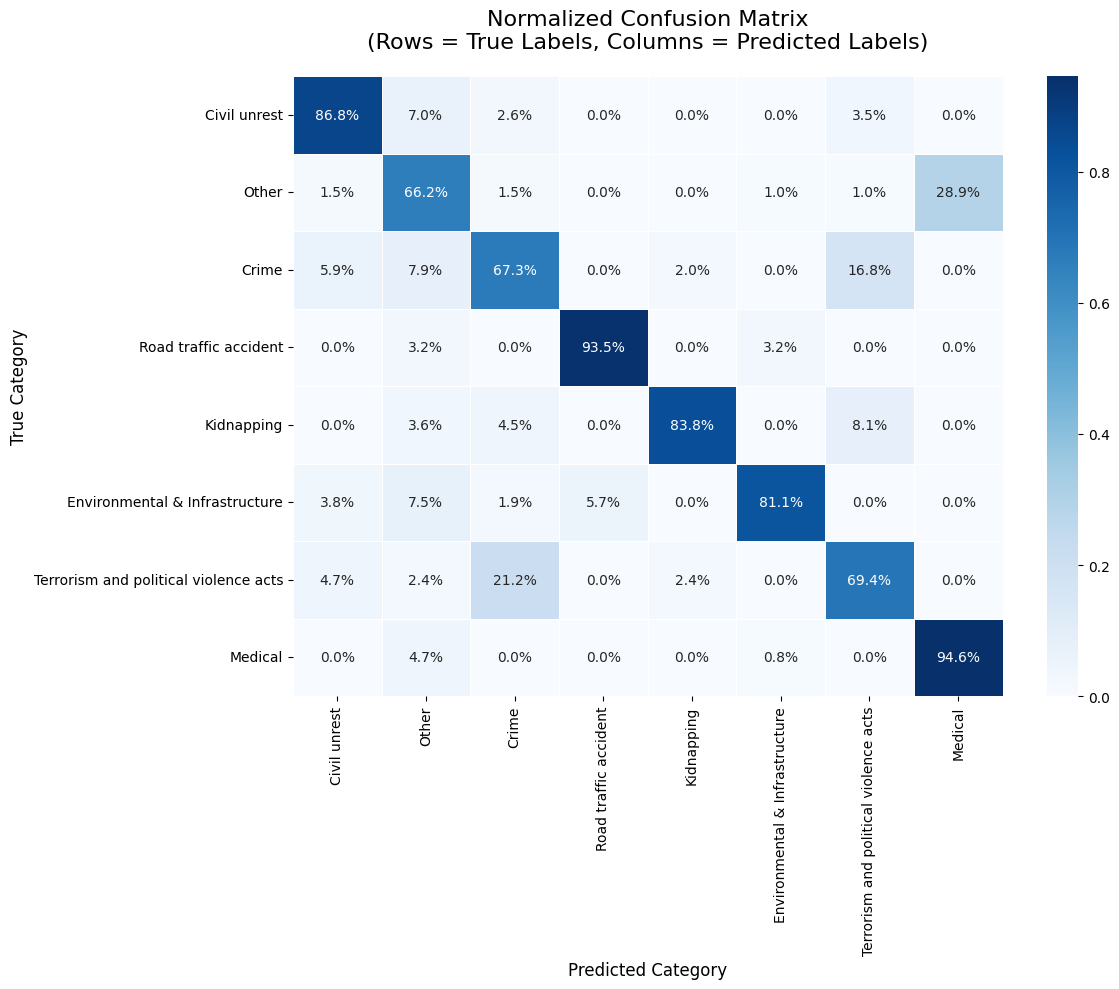

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(true_labels, llm_predictions, labels=categories)

cm_df = pd.DataFrame(cm, index=categories, columns=categories)

print("\nConfusion Matrix (Raw Counts):")
print(cm_df)



cm_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)



plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.1%',
    cmap='Blues',
    linewidths=.5
)

heatmap.set_title('Normalized Confusion Matrix\)', fontsize=16, pad=20)
heatmap.set_xlabel('Predicted Category', fontsize=12)
heatmap.set_ylabel('True Category', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
test_df.head(25)

,Final_Summary,Category,LLM_Predicted,Raw_Output
0,The Kwara State Government has reopened the Kw...,Civil unrest,Civil unrest,<|begin_of_text|><|start_header_id|>system<|en...
1,"Phrank Shaibu, Special Assistant to Atiku Abub...",Other,Other,<|begin_of_text|><|start_header_id|>system<|en...
2,"Minister of Interior, Rauf Aregbesola, has emp...",Other,Other,<|begin_of_text|><|start_header_id|>system<|en...
3,The Atiku-Okowa Presidential Campaign Organisa...,Other,Other,<|begin_of_text|><|start_header_id|>system<|en...
4,Troops from Operation Forest Sanity neutralize...,Crime,Terrorism and political violence acts,<|begin_of_text|><|start_header_id|>system<|en...
5,"Primate Elijah Ayodele, leader of INRI Evangel...",Other,Other,<|begin_of_text|><|start_header_id|>system<|en...
6,Edo State Governor Godwin Obaseki congratulate...,Other,Other,<|begin_of_text|><|start_header_id|>system<|en...
7,A fatal road crash occurred on the Lagos-Ibada...,Road traffic accident,Road traffic accident,<|begin_of_text|><|start_header_id|>system<|en...
8,The Kogi State government has approved a 65-ye...,Other,Other,<|begin_of_text|><|start_header_id|>system<|en...
9,"Two suspects, Nweke Joshua (19) and Chioma Oka...",Crime,Crime,<|begin_of_text|><|start_header_id|>system<|en...
